In [1]:
# from rgz_datamodules import RGZ_DataModule
from utils import Path_Handler
from rgz108k import RGZ108k 
from torch.utils.data import DataLoader
import torchvision.transforms as T

from matplotlib import pyplot as plt 

import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from umap import UMAP

In [2]:


device =  'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

paths = Path_Handler()._dict()

transform = T.Compose(
    [
        T.CenterCrop(70),
        T.ToTensor(),
        T.Normalize((0.008008896,), (0.05303395,)),
    ]
)


In [3]:
paths["rgz"]

PosixPath('/home/k22562dm/code/rgzeval/data')

In [4]:
# Load in RGZ dataset
# paths["rgz"] = '/home/k22562dm/code/rgzeval/data'

train_dataset = RGZ108k(paths["rgz"], train=True, transform=transform, cut_threshold= 20, mb_cut=True)
test_dataset = RGZ108k(paths["rgz"], train=False, transform=transform, cut_threshold= 20, mb_cut=True)

Removing duplicates from RGZ dataset...
Removed 7231 duplicate samples
Removing 28504 samples below angular size threshold.
Removed 1250 MiraBest samples from RGZ
(69015, 150, 150, 1)
Removing duplicates from RGZ dataset...
Removed 149 duplicate samples
Removing 493 samples below angular size threshold.
Removed 27 MiraBest samples from RGZ
(1224, 150, 150, 1)


In [5]:
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

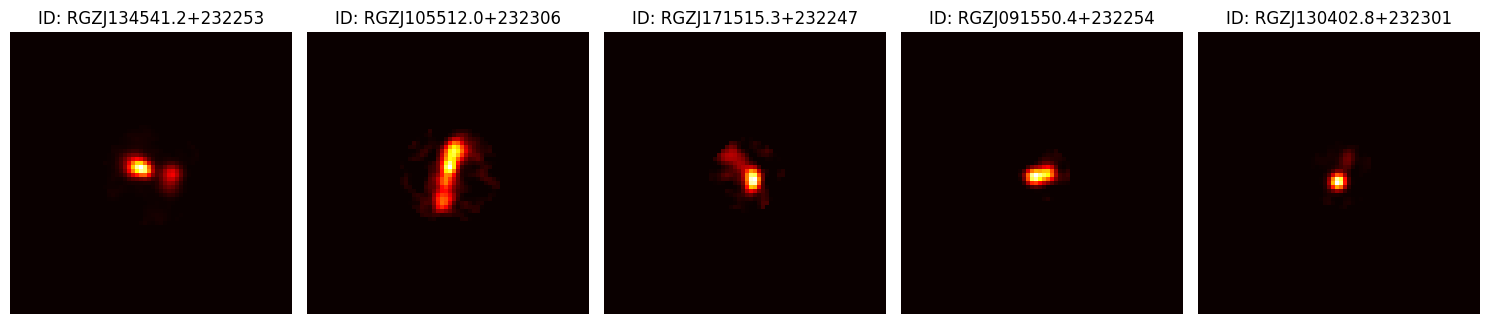

In [6]:
# Plot samples from the dataloader
def plot_samples(dataloader, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (x_batch, y_batch) in enumerate(dataloader):
        for j in range(num_samples):
            image = x_batch[j].squeeze().cpu().numpy()
            axes[j].imshow(image, cmap='hot')
            axes[j].set_title(f"ID: {y_batch['id'][j]}")
            axes[j].axis('off')
        break  # Only plot the first batch
    plt.tight_layout()
    plt.show()


plot_samples(train_loader, num_samples=5)

In [7]:
df = pd.read_csv('hmc_rgz.csv')


In [8]:
df_cut20 = df[df['las'] > 20]

In [11]:
df_cut20[df_cut20['Interval mean'] == 8 ].sort_values(by='Interval std', ascending=False)

,Unnamed: 0,id,las,HMC RGZ,HMC RGZ std,Interval mean,Interval std,pred entropy,mutual info,radio.ra,radio.dec
35955,36952,RGZJ134533.5+621107,116.102440,-9.735017,18.692194,8,6,0.682214,0.283763,206.389750,62.185301
35956,36953,RGZJ134534.1+621111,110.269551,-10.077323,18.196165,8,6,0.682386,0.255861,206.387734,62.185315
6675,6923,RGZJ162727.1+143627,97.002620,-9.560647,13.499609,8,5,0.658766,0.243382,246.862929,14.607772
42012,43137,RGZJ170141.6+235741,118.544439,-10.585210,14.505547,8,5,0.675830,0.305144,255.423459,23.961507
59210,60742,RGZJ161130.0+325826,117.864039,-9.758459,13.516835,8,5,0.688894,0.281781,242.875094,32.974165
88528,90799,RGZJ105848.3+252342,93.442486,-9.487388,13.383630,8,5,0.645105,0.302263,164.721999,25.395623
96188,98677,RGZJ161750.9+345556,104.671914,-8.429235,14.364888,8,5,0.655682,0.268499,244.461933,34.932343
82095,84193,RGZJ110729.8+210600,30.134005,-9.496113,10.663819,8,4,0.664316,0.377398,166.874625,21.099846
88232,90494,RGZJ135546.8+253423,129.424855,-9.248268,11.257689,8,4,0.691449,0.371564,208.944933,25.573094
337,354,RGZJ102832.0+231231,24.820409,-8.491942,9.776582,8,3,0.692238,0.206926,157.131873,23.207313


In [9]:
def visualize_samples_by_interval(dataloader, dataframe, interval_mean, num_samples=5, images_per_row=5):
    # Filter the dataframe for the specified interval mean
    filtered_df = dataframe[dataframe['Interval mean'] == interval_mean]
    rgz_ids = filtered_df['id'].tolist()  # Get the IDs and shuffle them

    # Initialize the plot
    # fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    rows = (num_samples + images_per_row - 1) // images_per_row  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 3, rows * 3))
    axes = axes.flatten()  # Flatten the axes for easier indexing
    
    sample_count = 0


    # Iterate through the dataloader
    for x_batch, y_batch in dataloader:
        for i in range(len(y_batch['id'])):
            if y_batch['id'][i] in rgz_ids:
                # Visualize the sample
                image = x_batch[i].squeeze().cpu().numpy()
                axes[sample_count].imshow(image, cmap='hot')
                axes[sample_count].set_title(f"ID: {y_batch['id'][i]}")
                axes[sample_count].axis('off')
                sample_count += 1

                # Stop once we have enough samples
                if sample_count == num_samples:
                    break
        if sample_count == num_samples:
            break
    # Hide unused axes
    for k in range(sample_count, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()


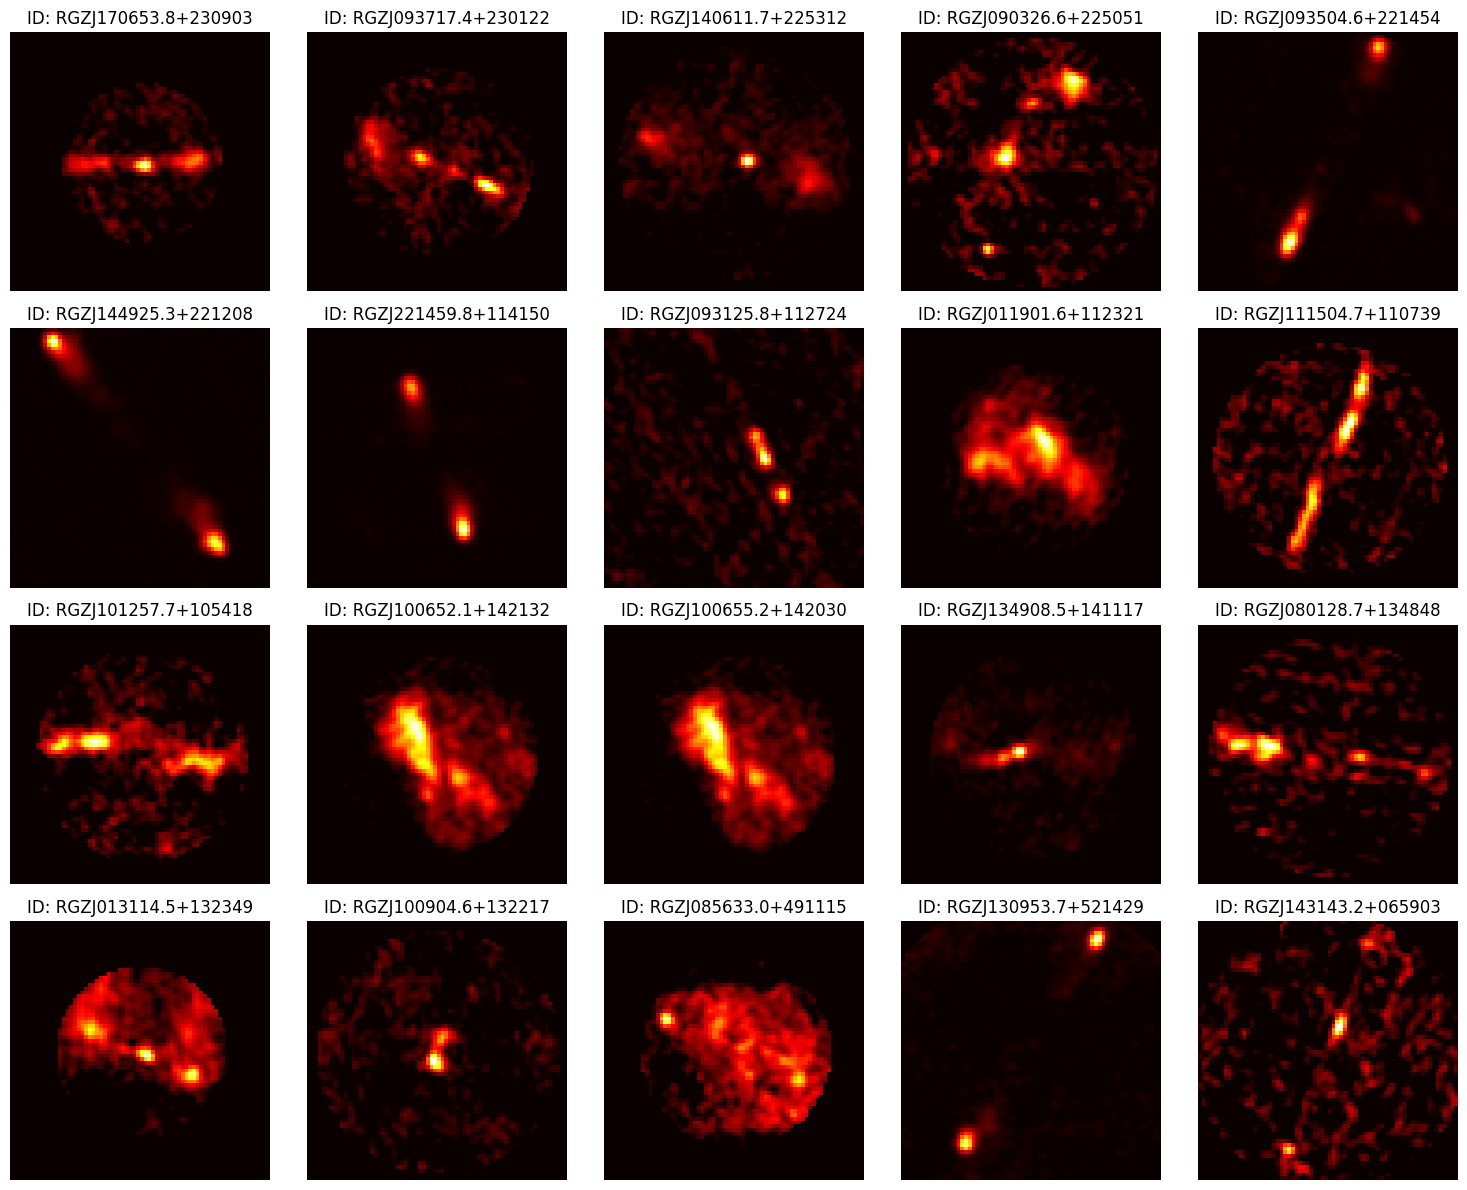

In [10]:

# Example usage
visualize_samples_by_interval(train_loader, df_cut20, interval_mean=6, num_samples=20, images_per_row=5)

In [17]:
# df_cut20[df_cut20['mutual info'] <0.1].sort_values(by='Interval mean', ascending=False)[:20]

In [11]:
def visualize_samples_by_mi(dataloader, dataframe, interval_mean, num_samples=5, images_per_row=5):
    # Filter the dataframe for the specified interval mean
    filtered_df = dataframe[dataframe['mutual info'] < interval_mean].sort_values(by='Interval mean', ascending=False)
    rgz_ids = filtered_df['id'].tolist()  # Get the IDs and shuffle them

    # Initialize the plot
    # fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    rows = (num_samples + images_per_row - 1) // images_per_row  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 3, rows * 3))
    axes = axes.flatten()  # Flatten the axes for easier indexing
    
    sample_count = 0


    # Iterate through the dataloader
    for x_batch, y_batch in dataloader:
        for i in range(len(y_batch['id'])):
            if y_batch['id'][i] in rgz_ids:
                # Visualize the sample
                image = x_batch[i].squeeze().cpu().numpy()
                axes[sample_count].imshow(image, cmap='hot')
                axes[sample_count].set_title(f"ID: {y_batch['id'][i]}")
                axes[sample_count].axis('off')
                sample_count += 1

                # Stop once we have enough samples
                if sample_count == num_samples:
                    break
        if sample_count == num_samples:
            break
    # Hide unused axes
    for k in range(sample_count, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()


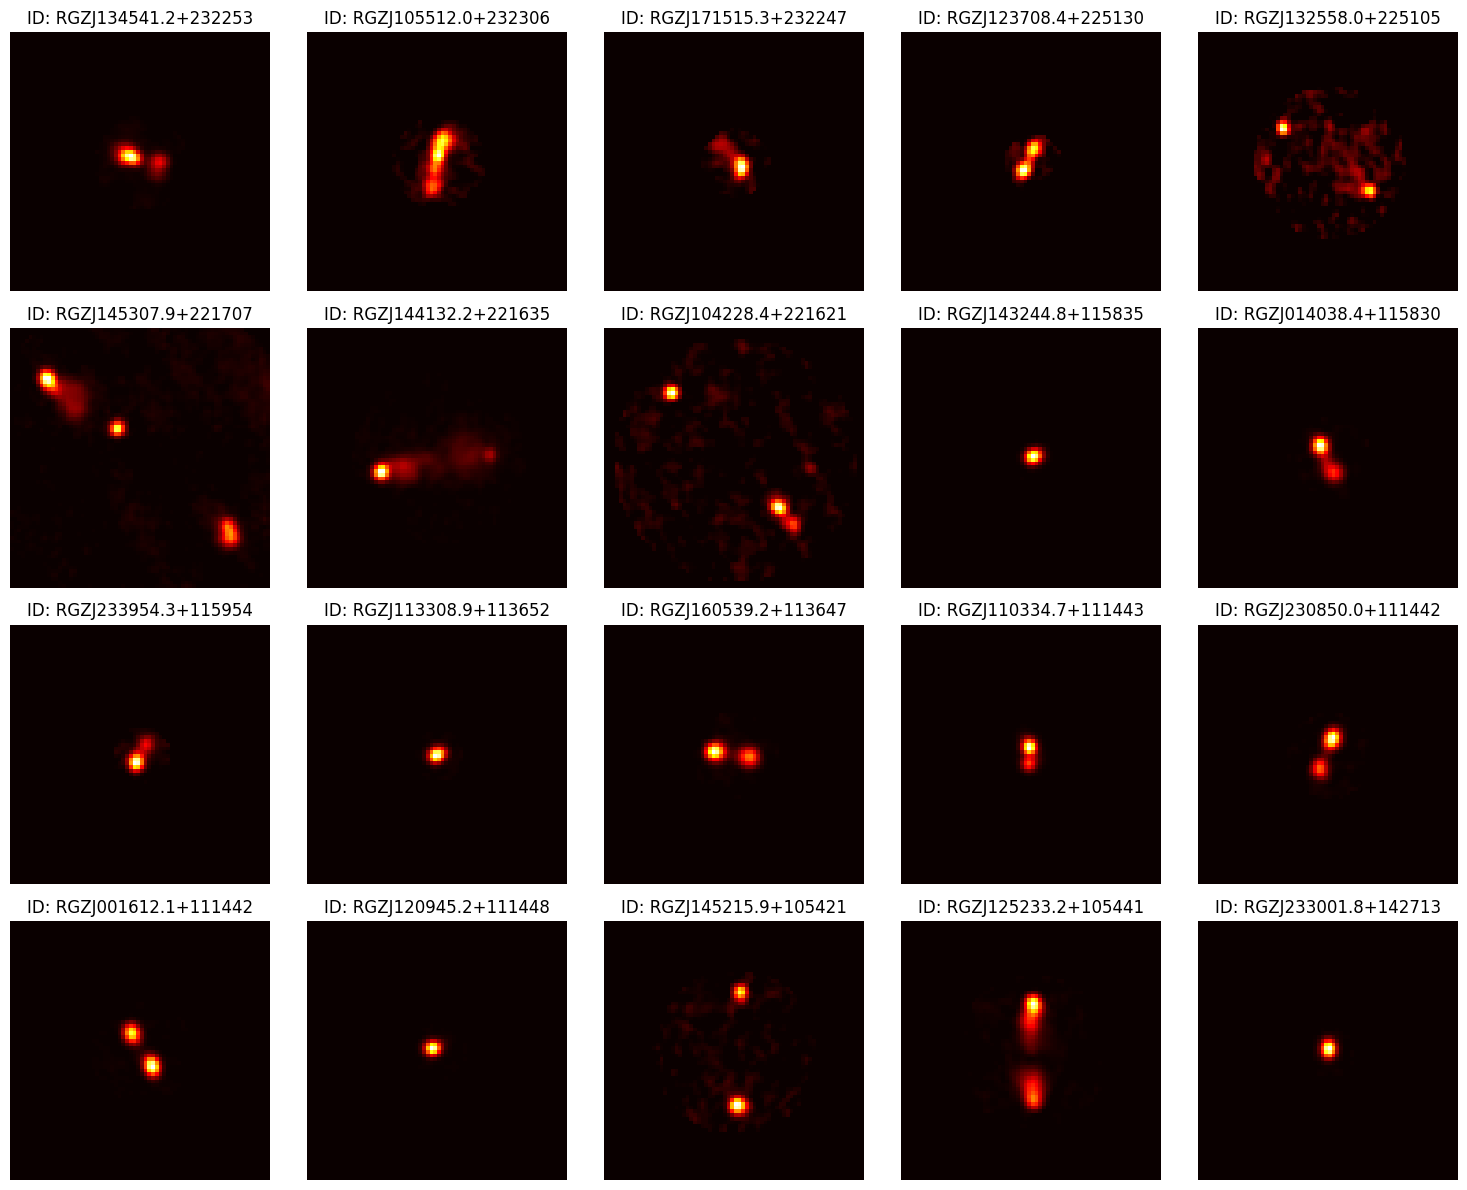

In [12]:

# Example usage
visualize_samples_by_mi(train_loader, df_cut20, interval_mean=0.01, num_samples=20, images_per_row=5)

In [19]:
# ok! now I need to attach the features to the rgz ids!
# import numpy as np
# rgz_trainset_features_ft = np.load('train_features_ft.npy', allow_pickle=True)

In [107]:
#code for removing duplicates in the DataFrame      


# Assuming you have a Pandas DataFrame 'df' with 'id', 'ra', and 'dec' columns
df = pd.read_csv('hmc_rgz.csv')

# Create a SkyCoord object from your RA and DEC columns
coords = SkyCoord(ra=df['radio.ra'].values*u.deg, dec=df['radio.dec'].values*u.deg)

# Define your search radius
search_radius = 10.0 * u.arcsec # Adjust this value as needed

# Perform a self-match to find pairs of sources within the search radius
idx1, idx2, d2d, d3d = coords.search_around_sky(coords, search_radius)

# The results idx1 and idx2 are the indices of the matched pairs in your original DataFrame.
# d2d is the on-sky separation of the matched pairs.

    

In [14]:
coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(206.42212  , 23.38192519), (217.8388964, 23.38094186),
     (163.7996598, 23.38497197), ..., (147.76422  , 38.87830278),
     (241.104644 , 38.8758728 ), (114.2461064, 38.87458333)]>

In [108]:
      
# Filter out self-matches
different_sources_mask = idx1 != idx2
idx1 = idx1[different_sources_mask]
idx2 = idx2[different_sources_mask]

# Identify the indices of the duplicate sources to be removed
# We want to keep one of each pair, so we'll mark the second one for removal.
# Using a set to keep track of indices already marked for removal
indices_to_remove = set()
for i in range(len(idx1)):
    # To avoid removing both sources in a pair, we sort them and add the larger index to the removal set
    indices_to_remove.add(max(idx1[i], idx2[i]))

# Create a new DataFrame without the duplicate sources
df_deduplicated = df.drop(index=list(indices_to_remove)).reset_index(drop=True)

print(f"Original number of sources: {len(df)}")
print(f"Number of sources after removing duplicates: {len(df_deduplicated)}")
print(f'Number of duplicate sources removed: {len(df) - len(df_deduplicated)}')
    

Original number of sources: 98769
Number of sources after removing duplicates: 96221
Number of duplicate sources removed: 2548


In [ ]:
df_deduplicated.drop(columns=['Unnamed: 0']).to_csv('hmc_rgz_deduplicated.csv', index=False)


In [113]:

# Load the deduplicated DataFrame
df_deduplicated = pd.read_csv('hmc_rgz_deduplicated.csv')

In [114]:
# example to see the dataframe columns that match a specific interval mean
df_deduplicated[df_deduplicated['Interval mean'] == 8].sort_values(by='Interval std', ascending=False)

,id,las,HMC RGZ,HMC RGZ std,Interval mean,Interval std,pred entropy,mutual info,radio.ra,radio.dec
34979,RGZJ134533.5+621107,116.102440,-9.735017,18.692194,8,6,0.682214,0.283763,206.389750,62.185301
6475,RGZJ162727.1+143627,97.002620,-9.560647,13.499609,8,5,0.658766,0.243382,246.862929,14.607772
40885,RGZJ170141.6+235741,118.544439,-10.585210,14.505547,8,5,0.675830,0.305144,255.423459,23.961507
57662,RGZJ161130.0+325826,117.864039,-9.758459,13.516835,8,5,0.688894,0.281781,242.875094,32.974165
86243,RGZJ105848.3+252342,93.442486,-9.487388,13.383630,8,5,0.645105,0.302263,164.721999,25.395623
93716,RGZJ161750.9+345556,104.671914,-8.429235,14.364888,8,5,0.655682,0.268499,244.461933,34.932343
79989,RGZJ110729.8+210600,30.134005,-9.496113,10.663819,8,4,0.664316,0.377398,166.874625,21.099846
85960,RGZJ135546.8+253423,129.424855,-9.248268,11.257689,8,4,0.691449,0.371564,208.944933,25.573094
324,RGZJ102832.0+231231,24.820409,-8.491942,9.776582,8,3,0.692238,0.206926,157.131873,23.207313


In [182]:
# 98769 - 96947 = 1822 duplicates removed

In [115]:
df_cut20_deduplicated = df_deduplicated[df_deduplicated['las'] > 20]
# 67835 sources left after applying the 20'' cut

In [117]:
df_cut20_deduplicated

,id,las,HMC RGZ,HMC RGZ std,Interval mean,Interval std,pred entropy,mutual info,radio.ra,radio.dec
0,RGZJ134541.2+232253,37.831507,-1.060241,5.297369,1,1,0.693147,2.980000e-08,206.422120,23.381925
2,RGZJ105512.0+232306,37.364087,-1.164064,7.521431,1,2,0.693147,0.000000e+00,163.799660,23.384972
4,RGZJ171515.3+232247,27.397689,-1.217391,5.540353,1,1,0.693147,2.980000e-08,258.815159,23.377849
6,RGZJ091550.4+232254,20.129228,-1.044939,5.665369,1,1,0.676335,2.907447e-01,138.960429,23.381641
7,RGZJ130402.8+232301,24.191293,-1.372522,4.413287,1,2,0.659026,3.034060e-01,196.011873,23.383691
...,...,...,...,...,...,...,...,...,...,...
96215,RGZJ112923.7+385312,43.292903,-1.289686,5.366755,1,1,0.691829,3.085427e-01,172.348577,38.886859
96216,RGZJ163124.9+385255,35.117839,-1.659154,6.388956,1,1,0.677894,3.127095e-01,247.854091,38.881808
96217,RGZJ120523.7+385253,23.062757,-1.047026,5.385272,1,1,0.691126,3.039314e-01,181.348908,38.881460
96219,RGZJ160426.0+385234,83.139939,-1.761516,4.637837,2,1,0.693147,2.442681e-01,241.104644,38.875873


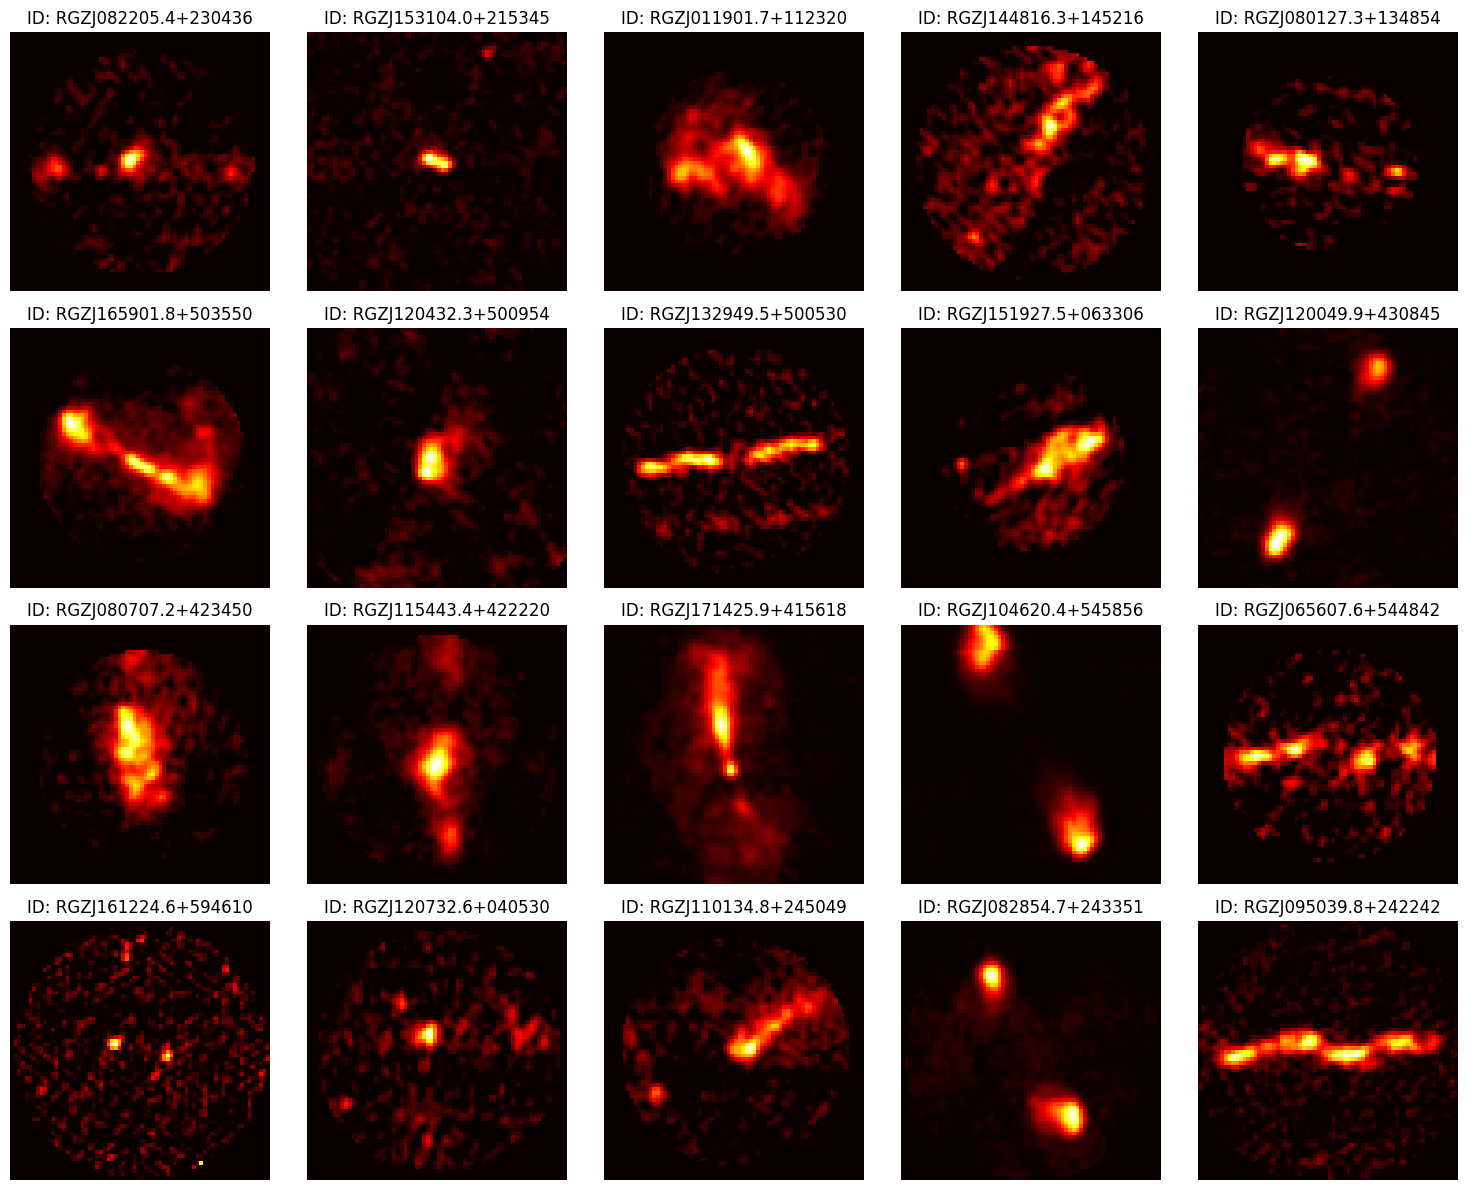

In [118]:
visualize_samples_by_interval(train_loader, df_cut20_deduplicated, interval_mean=7, num_samples=20, images_per_row=5)

In [119]:
rgz_trainset_features_ft = pd.read_parquet('rgz_features_train_ft.parquet')



NameError: name 'pd' is not defined

In [120]:
rgz_trainset_features_ft

,id,features
0,RGZJ134541.2+232253,"[0.4025808572769165, 0.6127355694770813, 0.997..."
1,RGZJ105512.0+232306,"[0.4113560914993286, 0.3947562575340271, 0.899..."
2,RGZJ171515.3+232247,"[0.554694652557373, 0.6984242796897888, 1.0905..."
3,RGZJ091550.4+232254,"[0.7309891581535339, 0.7256085276603699, 0.907..."
4,RGZJ130402.8+232301,"[0.4660899341106415, 0.8661344647407532, 0.886..."
...,...,...
69010,RGZJ112923.7+385312,"[0.021784991025924683, 0.3877369463443756, 0.9..."
69011,RGZJ163124.9+385255,"[0.08170144259929657, 0.52525395154953, 1.2978..."
69012,RGZJ120523.7+385253,"[0.3361985683441162, 0.621982216835022, 0.9842..."
69013,RGZJ160426.0+385234,"[0.34656187891960144, 1.0042890310287476, 0.40..."


In [129]:
merged_df = pd.merge(df_cut20_deduplicated, rgz_trainset_features_ft, on='id', how='left')

In [132]:
merged_df

,id,las,HMC RGZ,HMC RGZ std,Interval mean,Interval std,pred entropy,mutual info,radio.ra,radio.dec,features
0,RGZJ134541.2+232253,37.831507,-1.060241,5.297369,1,1,0.693147,2.980000e-08,206.422120,23.381925,"[0.4025808572769165, 0.6127355694770813, 0.997..."
1,RGZJ105512.0+232306,37.364087,-1.164064,7.521431,1,2,0.693147,0.000000e+00,163.799660,23.384972,"[0.4113560914993286, 0.3947562575340271, 0.899..."
2,RGZJ171515.3+232247,27.397689,-1.217391,5.540353,1,1,0.693147,2.980000e-08,258.815159,23.377849,"[0.554694652557373, 0.6984242796897888, 1.0905..."
3,RGZJ091550.4+232254,20.129228,-1.044939,5.665369,1,1,0.676335,2.907447e-01,138.960429,23.381641,"[0.7309891581535339, 0.7256085276603699, 0.907..."
4,RGZJ130402.8+232301,24.191293,-1.372522,4.413287,1,2,0.659026,3.034060e-01,196.011873,23.383691,"[0.4660899341106415, 0.8661344647407532, 0.886..."
...,...,...,...,...,...,...,...,...,...,...,...
67830,RGZJ112923.7+385312,43.292903,-1.289686,5.366755,1,1,0.691829,3.085427e-01,172.348577,38.886859,"[0.021784991025924683, 0.3877369463443756, 0.9..."
67831,RGZJ163124.9+385255,35.117839,-1.659154,6.388956,1,1,0.677894,3.127095e-01,247.854091,38.881808,"[0.08170144259929657, 0.52525395154953, 1.2978..."
67832,RGZJ120523.7+385253,23.062757,-1.047026,5.385272,1,1,0.691126,3.039314e-01,181.348908,38.881460,"[0.3361985683441162, 0.621982216835022, 0.9842..."
67833,RGZJ160426.0+385234,83.139939,-1.761516,4.637837,2,1,0.693147,2.442681e-01,241.104644,38.875873,"[0.34656187891960144, 1.0042890310287476, 0.40..."


In [135]:
merged_df = merged_df.dropna()

In [136]:
#hyperpatameters for differetn fits
PCA_COMPONENTS = 200 #200

UMAP_N_NEIGHBOURS = 75
UMAP_MIN_DIST = 0.01
METRIC = "cosine"

discard_fraction = 0.3

seed = 42

In [137]:


pca = PCA(n_components=PCA_COMPONENTS, random_state=seed)
umap = UMAP(
    n_components=2,
    n_neighbors=UMAP_N_NEIGHBOURS,
    min_dist=UMAP_MIN_DIST,
    metric="cosine",
    random_state=seed,
)

In [138]:
train_features_ft = np.vstack(merged_df['features'])

In [139]:
merged_df['features'].isnull().sum()

0

In [140]:
# fit features to PCA and UMAP
# train_features_ft = np.array(merged_df['features'])
pca.fit(train_features_ft)

umap.fit(pca.transform(train_features_ft))


# Transform the features using PCA
pca_features = pca.transform(train_features_ft)

umap_features = umap.transform(pca_features)
# Add the transformed features back to the dataframe
# merged_df['pca_features'] = list(pca_features)

/home/k22562dm/code/rgzeval/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/tmp/ipykernel_26522/708225094.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = ax.scatter(


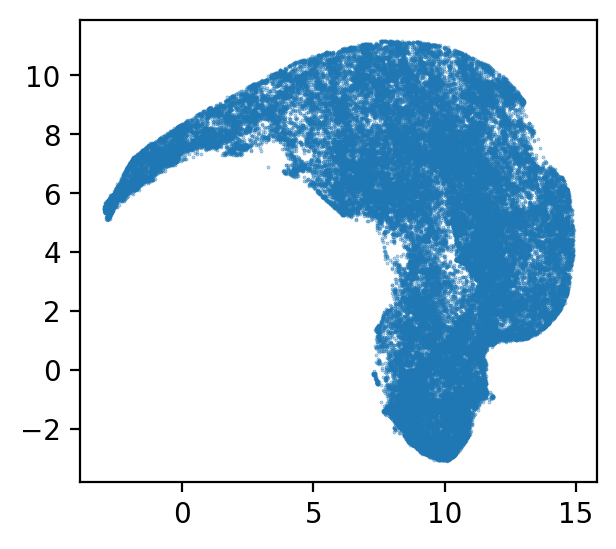

In [141]:
alpha = 0.6
marker_size = 0.1
fig_size = (10 / 3, 3)
fontsize = 9
marker = "o"

fig, ax = plt.subplots(dpi = 200)
fig.set_size_inches(fig_size)
scatter = ax.scatter(
    umap_features[:, 0],
    umap_features[:, 1],
    # c=reducer.targets,
    cmap="Spectral",
    s=marker_size,
    marker=marker,
    vmin=25,
    vmax=100,
    alpha=alpha,
)